In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# # get data files
# !wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
# !wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

## Import dataframe

In [3]:
import csv

def read_tsv(file_path: str):
    """Function to read tsv file

    Args:
        file_path (str): file path

    Returns:
        dataframe: dataFrame of data
    """
    with open(file_path, 'r') as f:
        tsv_reader = csv.DictReader(f, delimiter='\t', fieldnames=['is_ham', 'message'])
        data = [row for row in tsv_reader]
        
    df = pd.DataFrame(data)
    return df

In [4]:
train_data = read_tsv('./train-data.tsv')
valid_data = read_tsv('./valid-data.tsv')

In [5]:
train_data.head()

,is_ham,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


## EDA & Data Preprocessing

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4179 entries, 0 to 4178
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   is_ham   4179 non-null   object
 1   message  4179 non-null   object
dtypes: object(2)
memory usage: 65.4+ KB


In [7]:
train_data.describe()

,is_ham,message
count,4179,4179
unique,2,3935
top,ham,"sorry, i'll call later"
freq,3619,22


In [8]:
train_data['is_ham'].value_counts()

is_ham
ham     3619
spam     560
Name: count, dtype: int64

<Axes: xlabel='is_ham'>

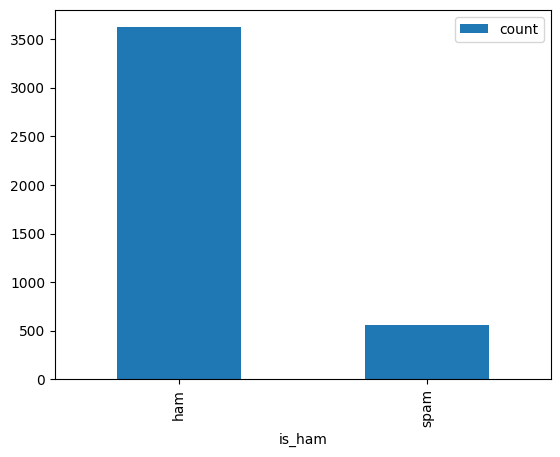

In [9]:
## Distribution of or not ham in data
train_data['is_ham'].value_counts().reset_index().plot(kind='bar', x='is_ham', y='count')

In dataset most of data is not spam, spam only 13% of training data

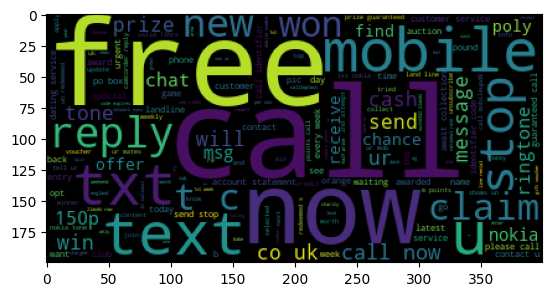

In [10]:
## Most Spam Keyword
import wordcloud
metatext = ''.join(train_data[train_data['is_ham'] != 'ham']['message'].to_list())
wc = wordcloud.WordCloud().generate(metatext)
plt.imshow(wc)
plt.show()

Most of ham message include `free`, `call` and also `now` in the message

In [11]:
# Map the is_ham column
train_data['is_ham'] = train_data['is_ham'].map({'ham':0, 'spam':1})

In [12]:
# Vectorization and apply it into Message column 
## also Split into Input and Output

from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(max_features=5000)
X = tf_idf.fit_transform(train_data['message']).toarray()
y = train_data['is_ham']

In [13]:
# Split data into 20% for testing purpose
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Do for Validation data

In [14]:
# Map the is_ham column
valid_data['is_ham'] = valid_data['is_ham'].map({'ham':0, 'spam':1})

X_valid = tf_idf.transform(valid_data['message']).toarray()
y_valid = valid_data['is_ham']

# Model Initialization

In [15]:
X_train.shape

(3343, 5000)

In [16]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(128, input_shape=(X_train.shape[1],), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 650,497 (2.48 MB)

 Trainable params: 650,497 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, mode='min'
)

In [19]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=[X_test, y_test],
    callbacks=[early_stopping],
)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7932 - loss: 0.5508 - val_accuracy: 0.8672 - val_loss: 0.1821
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8988 - loss: 0.1460 - val_accuracy: 0.9797 - val_loss: 0.0791
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9907 - loss: 0.0438 - val_accuracy: 0.9833 - val_loss: 0.0774
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9947 - loss: 0.0148 - val_accuracy: 0.9844 - val_loss: 0.0789
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0107 - val_accuracy: 0.9856 - val_loss: 0.0859
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0055 - val_accuracy: 0.9844 - val_loss: 0.0978
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0020 - val_accuracy: 0.9844 - val_loss: 0.1037
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accu

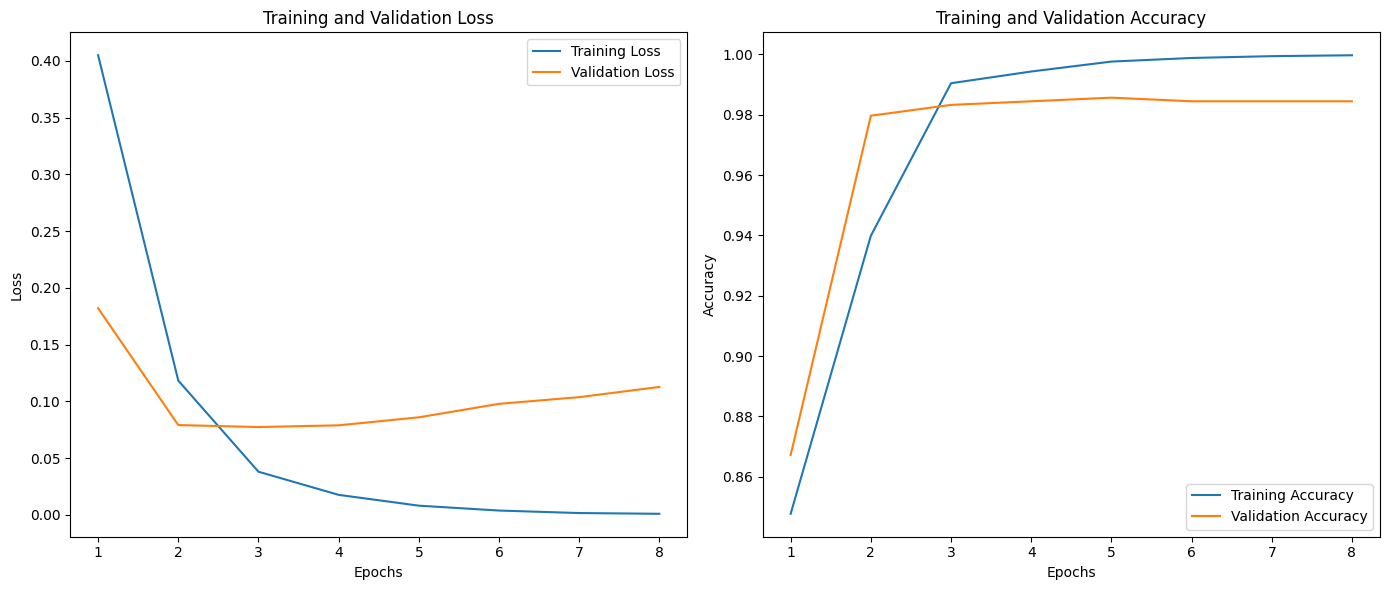

In [20]:
## Training graph
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs_range = range(1, len(train_loss) + 1)

# Plotting the Loss graph
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the Accuracy graph
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [21]:
loss, accuracy = model.evaluate(X_valid, y_valid)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.9874 - loss: 0.0550


## Prediction

In [33]:
new_text = "how are you doing today?"

In [37]:
text = tf_idf.transform([new_text]).toarray()
pred = model.predict(text)

if pred > 0.5:
    print("Spam")
else:
    print("Ham")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Ham


In [41]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  pred_text = tf_idf.transform([pred_text]).toarray()
  prediction = model.predict(pred_text)
  if prediction > 0.5:
    return "spam"
  else:
    return "ham"

pred_text = "sale today! to stop texts call 98912460324"

prediction = predict_message(pred_text)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
spam


In [47]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
You passed the challenge. Great job!
